In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
import warnings
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error, mean_absolute_error

warnings.filterwarnings('ignore')

df = pd.read_csv(r"C:\Users\chloe\OneDrive\Desktop\Data Analytics\Mental_Health_and_Social_Media_Balance_Dataset.csv")

def categorize_happiness(h):
    if 4 <= h < 8:
        return "Low"
    elif 8 <= h < 10:
        return "Medium"
    elif h == 10:
        return "High"
    else:
        return None

df["Happiness_Group"] = df["Happiness_Index(1-10)"].apply(categorize_happiness)
y = df['Happiness_Group']   

X = df[['Stress_Level(1-10)', 'Sleep_Quality(1-10)', 'Daily_Screen_Time(hrs)']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


  Happiness_Group  Count  Percentage
0          Medium    200        40.0
1            High    162        32.4
2             Low    138        27.6


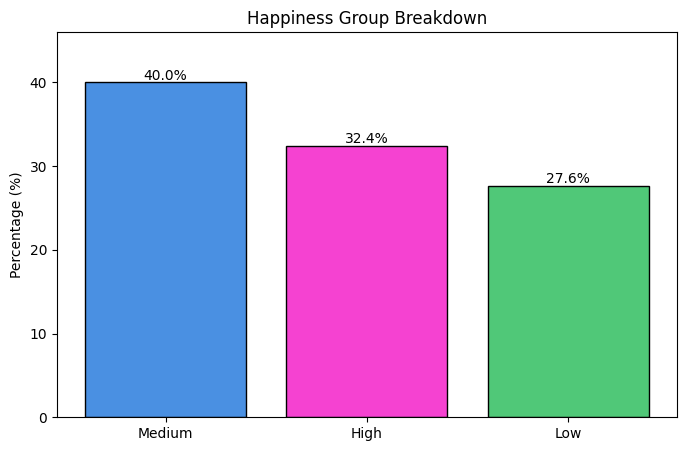

In [4]:
group_breakdown = df["Happiness_Group"].value_counts().reset_index()
group_breakdown.columns = ["Happiness_Group", "Count"]
group_breakdown["Percentage"] = (df["Happiness_Group"].value_counts(normalize=True).values * 100)

print(group_breakdown)


plt.figure(figsize=(8, 5))

bars = plt.bar(group_breakdown["Happiness_Group"],
               group_breakdown["Percentage"],
               color=["#4A90E2", "#f542d1", "#50C878"],
               edgecolor="black")

plt.ylabel("Percentage (%)")
plt.title("Happiness Group Breakdown")

for bar, pct in zip(bars, group_breakdown["Percentage"]):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height(),
             f"{pct:.1f}%",
             ha="center",
             va="bottom",
             fontsize=10)

plt.ylim(0, max(group_breakdown["Percentage"]) * 1.15)
plt.show()

In [5]:
classes = ["Medium", "High", "Low"]
probs = np.array([0.40, 0.324, 0.276])

def random_guess_accuracy_weighted(y_true, classes, probs, n_runs=1000):
    accs = []
    for _ in range(n_runs):
        random_preds = np.random.choice(classes, size=len(y_true), p=probs)
        acc = accuracy_score(y_true, random_preds)
        accs.append(acc)
    return np.mean(accs)

random_weighted_acc = random_guess_accuracy_weighted(y_test, classes, probs)
print("Weighted Random Guess Accuracy:", random_weighted_acc)

## Scaling happiness index for regression models

y_numeric = df["Happiness_Index(1-10)"]
scaler_y = StandardScaler()


y_scaled_2d = scaler_y.fit_transform(y_numeric.values.reshape(-1, 1))
y_scaled = y_scaled_2d.ravel()

X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y_scaled, test_size=0.2, random_state=42)


mean_pred = np.full_like(y_test1, y_train1.mean())

baseline_mse = mean_squared_error(y_test1, mean_pred)
baseline_rmse = np.sqrt(baseline_mse)
baseline_mae = mean_absolute_error(y_test1, mean_pred)

print(f"Baseline Mean Squared Error: {baseline_mae:.4f}")



Weighted Random Guess Accuracy: 0.3373399999999999
Baseline Mean Squared Error: 0.8734


In [6]:
# -----------------------
# 1. Logistic Regression
# -----------------------
lr = LogisticRegression(max_iter=1000, multi_class="multinomial")

params_log = {'C': [0.01, 0.1, 1, 10],
              'solver': ['lbfgs', 'saga']}

grid_log = GridSearchCV(lr, params_log, cv=5)
grid_log.fit(X_train, y_train)

best_lr = grid_log.best_estimator_
y_pred = best_lr.predict(X_test)
y_pred_proba = best_lr.predict_proba(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\nBest Logistic Regression params:", grid_log.best_params_)
print(f"Accuracy of the Logistic Regression model: {accuracy:.2f}")

# -----------------------
# 2. Random Forest Classifier
# -----------------------
rf = RandomForestClassifier(random_state=0)

params_rf = {'n_estimators': [100, 200, 300],
             'max_depth': [3, 5, 10, None],
             'min_samples_split': [2, 5, 10]}

grid_rf = GridSearchCV(rf, params_rf, cv=5, n_jobs=-1)
grid_rf.fit(X_train, y_train)

best_rf = grid_rf.best_estimator_
rf_pred = best_rf.predict(X_test)

accuracy = accuracy_score(y_test, rf_pred)

print("\nBest Random Forest params:", grid_rf.best_params_)
print(f"Accuracy of the Random Forest model: {accuracy:.2f}")

# -----------------------
# 3. Support Vector Machine (SVC)
# -----------------------
svc = svm.SVC()

params_svc = {'C': [0.1, 1, 10],
              'kernel': ['rbf', 'linear'],
              'gamma': ['scale', 'auto']}

grid_svc = GridSearchCV(svc, params_svc, cv=5, n_jobs=-1)
grid_svc.fit(X_train, y_train)

best_svc = grid_svc.best_estimator_
y_pred = best_svc.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)

print("\nBest SVM params:", grid_svc.best_params_)
print(f"Accuracy of the SVM model: {accuracy:.2f}")

# -----------------------
# 4. KNN Classifier
# -----------------------

knn = KNeighborsClassifier()

params_knn = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid_knn = GridSearchCV(knn, params_knn, cv=5, n_jobs=-1)
grid_knn.fit(X_train, y_train)

best_knn = grid_knn.best_estimator_
knn_pred = best_knn.predict(X_test)

accuracy = accuracy_score(y_test, knn_pred)

print("\nBest KNN params:", grid_knn.best_params_)
print(f"Accuracy of the KNN model: {accuracy:.2f}")





Best Logistic Regression params: {'C': 0.1, 'solver': 'lbfgs'}
Accuracy of the Logistic Regression model: 0.68

Best Random Forest params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy of the Random Forest model: 0.69

Best SVM params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}
Accuracy of the SVM model: 0.66

Best KNN params: {'n_neighbors': 9, 'p': 1, 'weights': 'uniform'}
Accuracy of the KNN model: 0.70


In [7]:
mse_best = {}

# -----------------------
# 1. Linear Regression
# -----------------------
lin = LinearRegression()

params_lin = {'fit_intercept': [True, False],
              'positive': [False, True]}

grid_lin = GridSearchCV(lin,
                        params_lin,
                        cv=5,
                        n_jobs=-1)

grid_lin.fit(X_train1, y_train1)

best_lin = grid_lin.best_estimator_
y_pred1 = best_lin.predict(X_test1)

mse_lin = mean_squared_error(y_test1, y_pred1)
r2 = r2_score(y_test1, y_pred1)

mse_best["Linear Regression (Reg, tuned)"] = mse_lin

print("\nBest Linear Regression params:", grid_lin.best_params_)
print(f"MSE: {mse_lin:.4f}")
print(f"R²: {r2:.4f}")

# -----------------------
# 2. Random Forest (Regressor)
# -----------------------
rf = RandomForestRegressor(random_state=42)


params_rf = {'n_estimators': [100, 200, 300],
             'max_depth': [3, 5, 10, None],
             'min_samples_split': [2, 5, 10]}


grid_rf = GridSearchCV(rf,
                       params_rf,
                       cv=5,
                       n_jobs=-1)

grid_rf.fit(X_train1, y_train1)

best_rf_reg = grid_rf.best_estimator_
y_pred_rf = best_rf_reg.predict(X_test1)

mse_rf = mean_squared_error(y_test1, y_pred_rf)
r2 = r2_score(y_test1, y_pred_rf)

mse_best["Random Forest (Reg, tuned)"] = mse_rf

print("\nBest Random Forest params:", grid_rf.best_params_)
print("\n[Random Forest Regressor Results]")
print(f"MSE: {mse_rf:.4f}")
print(f"R²: {r2:.4f}")

# -----------------------
# 3. Support Vector Machine (SVR)
# -----------------------
svr = SVR()

params_svr = {'C': [0.1, 1, 10],
              'kernel': ['rbf', 'linear'],
              'gamma': ['scale', 'auto']}


grid_svr = GridSearchCV(svr,
                        params_svr,
                        cv=5,
                        n_jobs=-1)

grid_svr.fit(X_train1, y_train1)

best_svr = grid_svr.best_estimator_
y_pred_svr = best_svr.predict(X_test1)

mse_svr = mean_squared_error(y_test1, y_pred_svr)
r2 = r2_score(y_test1, y_pred_svr)

mse_best["SVR (Reg, tuned)"] = mse_svr

print("\nBest SVR params:", grid_svr.best_params_)
print("\n[SVR Results]")
print(f"MSE: {mse_svr:.4f}")
print(f"R²: {r2:.4f}")

# -----------------------
# 4. KNN Regressor
# -----------------------

knn = KNeighborsRegressor()

params_knn = {'n_neighbors': [3, 5, 7, 9],
              'weights': ['uniform', 'distance'],
              'p': [1, 2]}

grid_knn = GridSearchCV(knn,
                        params_knn,
                        cv=5,
                        n_jobs=-1)

grid_knn.fit(X_train1, y_train1)

best_knn_reg = grid_knn.best_estimator_
y_pred_knn = best_knn_reg.predict(X_test1)

mse_knn = mean_squared_error(y_test1, y_pred_knn)
r2 = r2_score(y_test1, y_pred_knn)

mse_best["KNN (Reg, tuned)"] = mse_knn

print("\nBest KNN Regressor params:", grid_knn.best_params_)
print("\n[KNN Regressor Results]")
print(f"MSE: {mse_knn:.4f}")
print(f"R²:  {r2:.4f}")


Best Linear Regression params: {'fit_intercept': True, 'positive': False}
MSE: 0.4006
R²: 0.6090

Best Random Forest params: {'max_depth': 5, 'min_samples_split': 10, 'n_estimators': 300}

[Random Forest Regressor Results]
MSE: 0.3420
R²: 0.6662

Best SVR params: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}

[SVR Results]
MSE: 0.4023
R²: 0.6073

Best KNN Regressor params: {'n_neighbors': 9, 'p': 2, 'weights': 'uniform'}

[KNN Regressor Results]
MSE: 0.3544
R²:  0.6541


In [8]:
## This code was provided by Chat GPT in order to prepare for computing bin accuracy from converted regression predictions

def binned_accuracy(true_vals, pred_vals):
    true_bins = [categorize_happiness(h) for h in true_vals]
    pred_bins = [categorize_happiness(h) for h in pred_vals]

    valid_idx = [i for i, (t, p) in enumerate(zip(true_bins, pred_bins))
                 if t is not None and p is not None]

    y_true_valid = [true_bins[i] for i in valid_idx]
    y_pred_valid = [pred_bins[i] for i in valid_idx]

    return accuracy_score(y_true_valid, y_pred_valid)

# -------------------------------------------------------
# Undo scaling 
# -------------------------------------------------------

y_test_orig = scaler_y.inverse_transform(y_test1.reshape(-1, 1)).ravel()

numeric_accs = {}

# -------------------------------------------------------
# BEST NUMERIC MODELS 
# -------------------------------------------------------

# 1) Linear Regression

lin = LinearRegression(fit_intercept=False, positive=False)
lin.fit(X_train1, y_train1)

lin_pred_scaled = lin.predict(X_test1)

lin_pred_orig = scaler_y.inverse_transform(lin_pred_scaled.reshape(-1, 1)).ravel()

numeric_accs["Linear Regression (Reg)"] = binned_accuracy(y_test_orig, lin_pred_orig)


# 2) Random Forest Regressor

rf_reg = RandomForestRegressor(max_depth=5,
                               min_samples_split=10,
                               n_estimators=300,
                               random_state=42)

rf_reg.fit(X_train1, y_train1)

rf_reg_pred_scaled = rf_reg.predict(X_test1)

rf_reg_pred_orig = scaler_y.inverse_transform(rf_reg_pred_scaled.reshape(-1, 1)).ravel()

numeric_accs["Random Forest (Reg)"] = binned_accuracy(y_test_orig, rf_reg_pred_orig)

# 3) SVR Regressor

svr_reg = SVR(C=10,
              gamma='scale',
              kernel='linear')

svr_reg.fit(X_train1, y_train1)

svr_pred_scaled = svr_reg.predict(X_test1)

svr_pred_orig = scaler_y.inverse_transform(svr_pred_scaled.reshape(-1, 1)).ravel()

numeric_accs["SVR (Reg)"] = binned_accuracy(y_test_orig, svr_pred_orig)

# 4) KNN Regressor

knn_reg = KNeighborsRegressor(n_neighbors=9,
                              p=1,
                              weights='uniform')

knn_reg.fit(X_train1, y_train1)

knn_reg_pred_scaled = knn_reg.predict(X_test1)

knn_reg_pred_orig = scaler_y.inverse_transform(knn_reg_pred_scaled.reshape(-1, 1)).ravel()

numeric_accs["KNN (Reg)"] = binned_accuracy(y_test_orig, knn_reg_pred_orig)

# -------------------------------------------------------
# BEST CATEGORICAL MODELS 
# -------------------------------------------------------
cat_accs = {}

# 1) Logistic Regression

log_clf = LogisticRegression(C=1,
                             solver='lbfgs',
                             multi_class='multinomial',
                             max_iter=1000)

log_clf.fit(X_train, y_train)

log_pred = log_clf.predict(X_test)

cat_accs["Logistic Regression (Clf)"] = accuracy_score(y_test, log_pred)

# 2) Random Forest Classifier

rf_clf = RandomForestClassifier(max_depth=5,
                                min_samples_split=10,
                                n_estimators=200,
                                random_state=42)

rf_clf.fit(X_train, y_train)

rf_clf_pred = rf_clf.predict(X_test)

cat_accs["Random Forest (Clf)"] = accuracy_score(y_test, rf_clf_pred)

# 3) SVM Classifier

svc_clf = SVC(C=0.1,
              gamma='scale',
              kernel='linear')

svc_clf.fit(X_train, y_train)

svc_pred = svc_clf.predict(X_test)

cat_accs["SVM (Clf)"] = accuracy_score(y_test, svc_pred)

# 4) KNN Classifier

knn_clf = KNeighborsClassifier(n_neighbors=9,
                               p=1,
                               weights='uniform')

knn_clf.fit(X_train, y_train)

knn_clf_pred = knn_clf.predict(X_test)

cat_accs["KNN (Clf)"] = accuracy_score(y_test, knn_clf_pred)

all_models = list(numeric_accs.keys()) + list(cat_accs.keys())
all_accs = list(numeric_accs.values()) + list(cat_accs.values())
all_types = (["Numeric (binned)"] * 4) + (["Categorical"] * 4)

acc_df = pd.DataFrame({"Model": all_models,
                       "Accuracy": all_accs,
                       "Type": all_types})

print("\nFINAL ACCURACY COMPARISON:")
print(acc_df)



FINAL ACCURACY COMPARISON:
                       Model  Accuracy              Type
0    Linear Regression (Reg)  0.544444  Numeric (binned)
1        Random Forest (Reg)  0.490000  Numeric (binned)
2                  SVR (Reg)  0.534091  Numeric (binned)
3                  KNN (Reg)  0.570000  Numeric (binned)
4  Logistic Regression (Clf)  0.670000       Categorical
5        Random Forest (Clf)  0.660000       Categorical
6                  SVM (Clf)  0.710000       Categorical
7                  KNN (Clf)  0.700000       Categorical


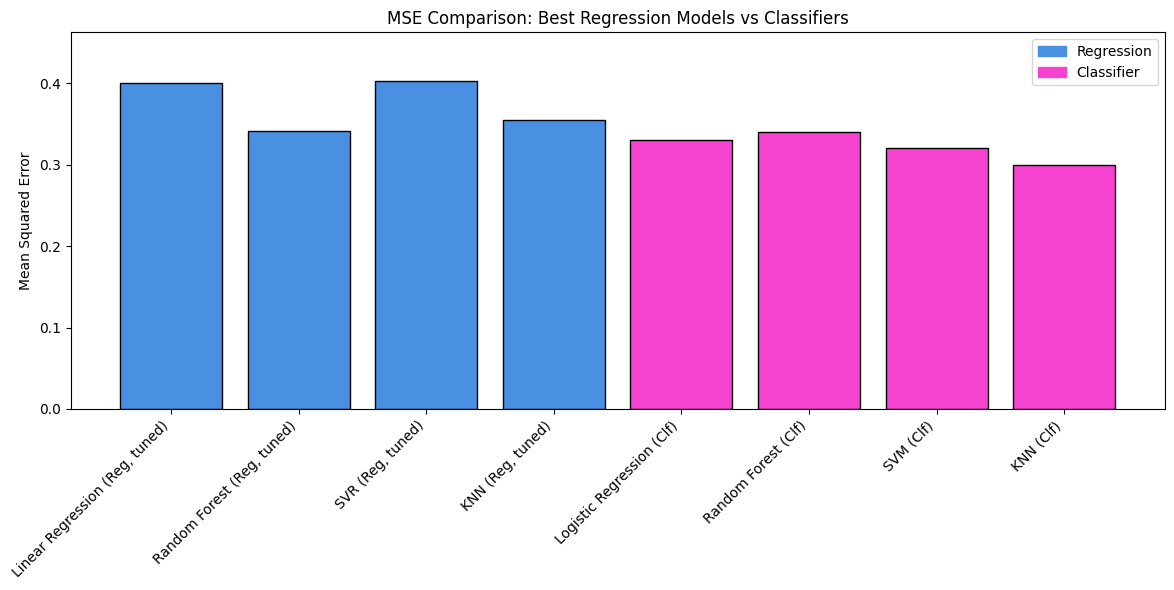

In [9]:
mapping = {"Low": 0, "Medium": 1, "High": 2}

y_test_num = y_test.map(mapping)

# Logistic Regression (clf)
log_pred_num = pd.Series(log_pred).map(mapping)
mse_best["Logistic Regression (Clf)"] = mean_squared_error(y_test_num, log_pred_num)

# Random Forest Classifier
rf_clf_pred_num = pd.Series(rf_clf_pred).map(mapping)
mse_best["Random Forest (Clf)"] = mean_squared_error(y_test_num, rf_clf_pred_num)

# SVM Classifier
svc_pred_num = pd.Series(svc_pred).map(mapping)
mse_best["SVM (Clf)"] = mean_squared_error(y_test_num, svc_pred_num)

# KNN Classifier
knn_clf_pred_num = pd.Series(knn_clf_pred).map(mapping)
mse_best["KNN (Clf)"] = mean_squared_error(y_test_num, knn_clf_pred_num)

mse_df = pd.DataFrame({"Model": list(mse_best.keys()),
                       "MSE": list(mse_best.values())})

mse_df["Type"] = mse_df["Model"].apply(lambda m: "Categorical" if "(Clf)" in m else "Numeric (binned)")

color_map = {"Numeric (binned)": "#4A90E2",
             "Categorical": "#f542d1"}

colors = [color_map[t] for t in mse_df["Type"]]


plt.figure(figsize=(12, 6))
x = np.arange(len(mse_df))

plt.bar(x, mse_df["MSE"], color=colors, edgecolor="black")

plt.xticks(x, mse_df["Model"], rotation=45, ha='right')
plt.ylabel("Mean Squared Error")
plt.title("MSE Comparison: Best Regression Models vs Classifiers")

plt.ylim(0, mse_df["MSE"].max() * 1.15)

import matplotlib.patches as mpatches
reg_patch = mpatches.Patch(color="#4A90E2", label="Regression")
clf_patch = mpatches.Patch(color="#f542d1", label="Classifier")

plt.legend(handles=[reg_patch, clf_patch])

plt.tight_layout()
plt.show()


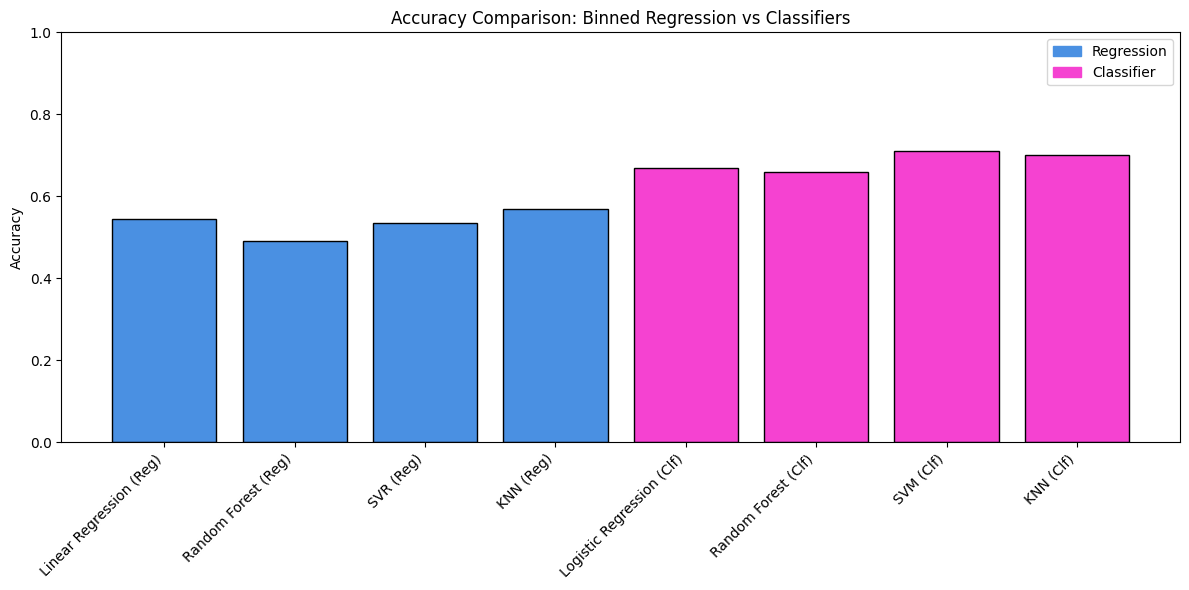

In [10]:
# Color map:
color_map = {"Numeric (binned)": "#4A90E2",
             "Categorical": "#f542d1"}

colors = [color_map[t] for t in acc_df["Type"]]

plt.figure(figsize=(12, 6))

x = np.arange(len(acc_df))
plt.bar(x, acc_df["Accuracy"], color=colors, edgecolor="black")

plt.xticks(x, acc_df["Model"], rotation=45, ha='right')
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.title("Accuracy Comparison: Binned Regression vs Classifiers")

# Create legend patches
import matplotlib.patches as mpatches
reg_patch = mpatches.Patch(color="#4A90E2", label="Regression")
clf_patch = mpatches.Patch(color="#f542d1", label="Classifier")

plt.legend(handles=[reg_patch, clf_patch])

plt.tight_layout()
plt.show()


In [11]:
feature_names = X.columns.tolist()
all_importances = {}

def perm_import(model, X_val, y_val, model_name, scoring):
    result = permutation_importance(model,
                                    X_val,
                                    y_val,
                                    n_repeats=30,
                                    random_state=42,
                                    scoring=scoring)
    
    importances = result.importances_mean
    all_importances[model_name] = dict(zip(feature_names, importances))


# -------------------------------------------------------
# REGRESSION MODELS 
# -------------------------------------------------------

perm_import(lin,     X_test1, y_test1, "Linear Regression (Reg)", scoring="r2")
perm_import(rf_reg,  X_test1, y_test1, "Random Forest (Reg)",    scoring="r2")
perm_import(svr_reg, X_test1, y_test1, "SVR (Reg)",              scoring="r2")
perm_import(knn_reg, X_test1, y_test1, "KNN (Reg)",              scoring="r2")


# -------------------------------------------------------
# CLASSIFICATION MODELS 
# -------------------------------------------------------

perm_import(log_clf, X_test, y_test, "Logistic Regression (Clf)", scoring="accuracy")
perm_import(rf_clf,  X_test, y_test, "Random Forest (Clf)",       scoring="accuracy")
perm_import(svc_clf, X_test, y_test, "SVM (Clf)",                 scoring="accuracy")
perm_import(knn_clf, X_test, y_test, "KNN (Clf)",                 scoring="accuracy")


df_importances = pd.DataFrame(all_importances).T
print("\nPERMUTATION IMPORTANCE BY MODEL:")
print(df_importances)


PERMUTATION IMPORTANCE BY MODEL:
                           Stress_Level(1-10)  Sleep_Quality(1-10)  \
Linear Regression (Reg)              0.441304             0.350046   
Random Forest (Reg)                  0.423653             0.110958   
SVR (Reg)                            0.502802             0.203541   
KNN (Reg)                            0.342264             0.173567   
Logistic Regression (Clf)            0.229000             0.121667   
Random Forest (Clf)                  0.156333             0.077000   
SVM (Clf)                            0.268000             0.154333   
KNN (Clf)                            0.212667             0.132333   

                           Daily_Screen_Time(hrs)  
Linear Regression (Reg)                 -0.002586  
Random Forest (Reg)                      0.164178  
SVR (Reg)                                0.018981  
KNN (Reg)                                0.078530  
Logistic Regression (Clf)                0.008667  
Random Forest (Clf)    

In [12]:
rank_df = df_importances.rank(ascending=False, axis=1)
print("\nFeature Ranks for Each Model:")
print(rank_df)

avg_importance = df_importances.mean(axis=0)
print("\nAverage Importance Across All Models:")
print(avg_importance)

final_ranking = avg_importance.sort_values(ascending=False)
print("\nFinal Overall Ranking (Most t0 Least Important):")
print(final_ranking)



Feature Ranks for Each Model:
                           Stress_Level(1-10)  Sleep_Quality(1-10)  \
Linear Regression (Reg)                   1.0                  2.0   
Random Forest (Reg)                       1.0                  3.0   
SVR (Reg)                                 1.0                  2.0   
KNN (Reg)                                 1.0                  2.0   
Logistic Regression (Clf)                 1.0                  2.0   
Random Forest (Clf)                       1.0                  2.0   
SVM (Clf)                                 1.0                  2.0   
KNN (Clf)                                 1.0                  2.0   

                           Daily_Screen_Time(hrs)  
Linear Regression (Reg)                       3.0  
Random Forest (Reg)                           2.0  
SVR (Reg)                                     3.0  
KNN (Reg)                                     3.0  
Logistic Regression (Clf)                     3.0  
Random Forest (Clf)       

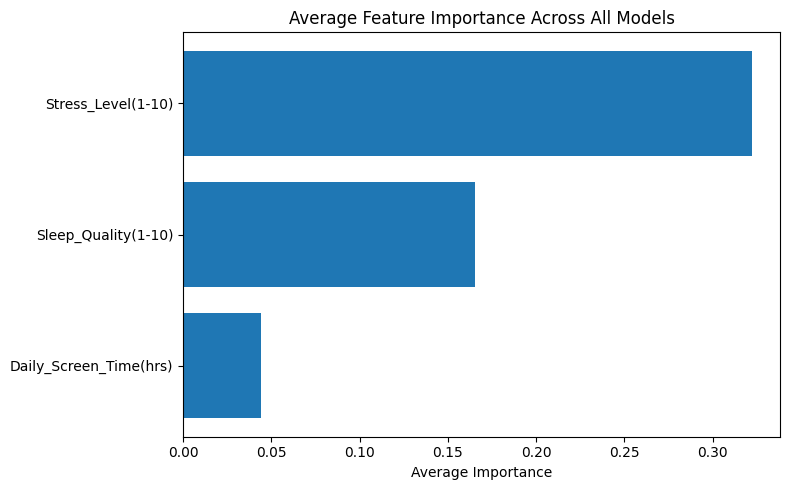

In [25]:
avg_table = avg_importance.sort_values(ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(avg_table.index, avg_table.values)
plt.xlabel("Average Importance")
plt.title("Average Feature Importance Across All Models")
plt.tight_layout()
plt.show()

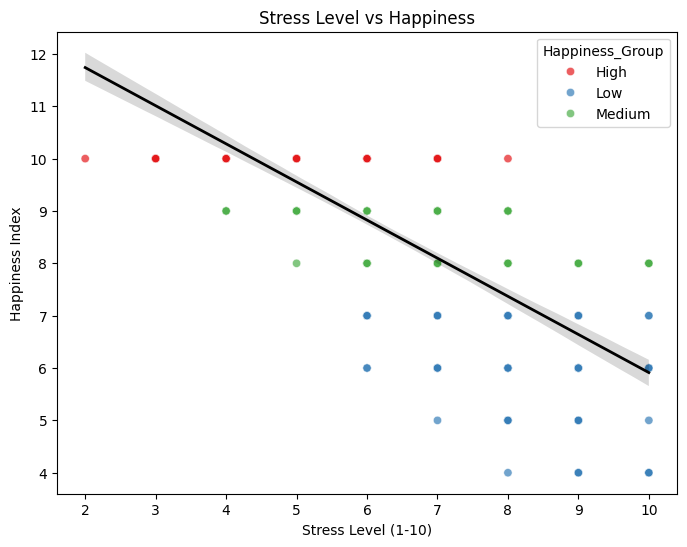

In [14]:
plt.figure(figsize=(8,6))

sns.scatterplot(x="Stress_Level(1-10)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

sns.regplot(x="Stress_Level(1-10)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2})

plt.title("Stress Level vs Happiness")
plt.xlabel("Stress Level (1-10)")
plt.ylabel("Happiness Index")
plt.show()






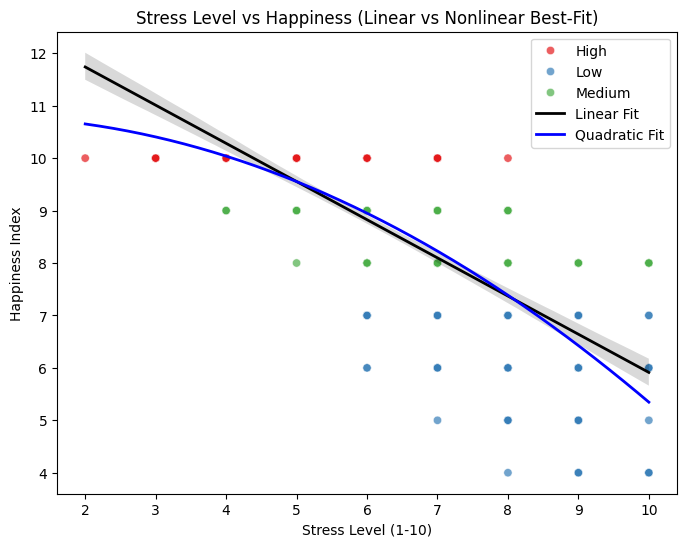

Linear R²: 0.5434834147684227
Quadratic R²: 0.5581249894315898
3rd Degree Quadratic R²: 0.5695700030579233


In [15]:
plt.figure(figsize=(8,6))

# ---------------------------------------------------------
# Scatterplot
# ---------------------------------------------------------
sns.scatterplot(x="Stress_Level(1-10)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

# ---------------------------------------------------------
# Linear Regression Line
# ---------------------------------------------------------
sns.regplot(x="Stress_Level(1-10)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2},
            label="Linear Fit")

# ---------------------------------------------------------
# Polynomial Regression 
# ---------------------------------------------------------
x = df["Stress_Level(1-10)"].values
y = df["Happiness_Index(1-10)"].values

coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_range = np.linspace(x.min(), x.max(), 200)
y_pred_poly = poly(x_range)

plt.plot(x_range, y_pred_poly, color="blue", linewidth=2, label="Quadratic Fit")

plt.title("Stress Level vs Happiness (Linear vs Nonlinear Best-Fit)")
plt.xlabel("Stress Level (1-10)")
plt.ylabel("Happiness Index")
plt.legend()
plt.show()

# ---------------------------------------------------------
# R^2 Calculations
# ---------------------------------------------------------
coeffs_lin = np.polyfit(x, y, 1)
lin = np.poly1d(coeffs_lin)
y_pred_lin = lin(x)

r2_linear = r2_score(y, y_pred_lin)

coeffs2 = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs2)

y_pred_quad = poly(x)
r2_quadratic = r2_score(y, y_pred_quad)

coeffs3 = np.polyfit(x, y, 3)
poly3 = np.poly1d(coeffs3)

y_pred_quad3 = poly3(x)
r2_quadratic3 = r2_score(y, y_pred_quad3)

print("Linear R²:", r2_linear)
print("Quadratic R²:", r2_quadratic)
print("3rd Degree Quadratic R²:", r2_quadratic3)

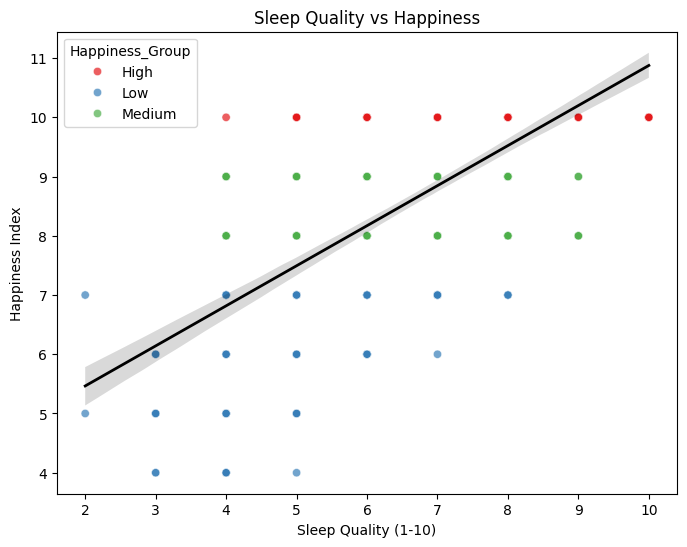

In [16]:
plt.figure(figsize=(8,6))

sns.scatterplot(x="Sleep_Quality(1-10)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

sns.regplot(x="Sleep_Quality(1-10)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2})

plt.title("Sleep Quality vs Happiness")
plt.xlabel("Sleep Quality (1-10)")
plt.ylabel("Happiness Index")
plt.show()



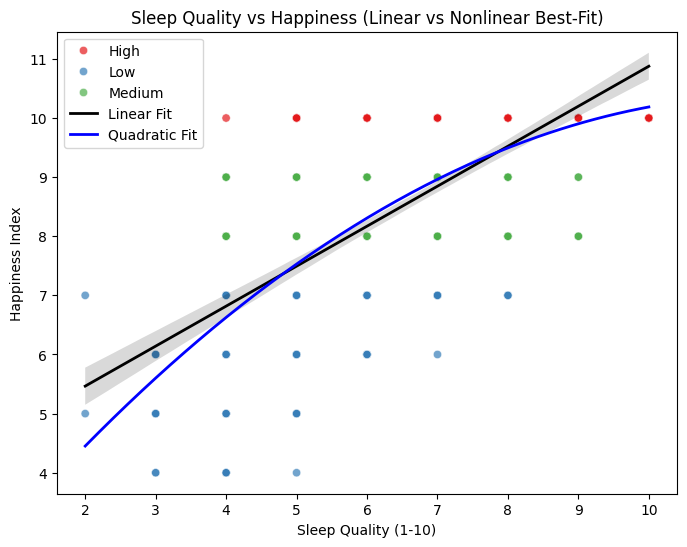

Linear R²: 0.5434834147684227
Quadratic R²: 0.47510932719495347
3rd Degree Quadratic R²: -1.505364487060707


In [17]:
plt.figure(figsize=(8,6))

# ---------------------------------------------------------
# Scatterplot
# ---------------------------------------------------------
sns.scatterplot(x="Sleep_Quality(1-10)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

# ---------------------------------------------------------
# Linear Regression Line 
# ---------------------------------------------------------
sns.regplot(x="Sleep_Quality(1-10)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2},
            label="Linear Fit")

# ---------------------------------------------------------
# Polynomial Regression 
# ---------------------------------------------------------
x = df["Sleep_Quality(1-10)"].values
y = df["Happiness_Index(1-10)"].values

coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_range = np.linspace(x.min(), x.max(), 200)
y_pred_poly = poly(x_range)

plt.plot(x_range, y_pred_poly, color="blue", linewidth=2, label="Quadratic Fit")

plt.title("Sleep Quality vs Happiness (Linear vs Nonlinear Best-Fit)")
plt.xlabel("Sleep Quality (1-10)")
plt.ylabel("Happiness Index")
plt.legend()
plt.show()

# ---------------------------------------------------------
# R^2 Calculations
# ---------------------------------------------------------

r2_linear = r2_score(y, y_pred_lin)

y_pred_quad = poly(x)
r2_quadratic = r2_score(y, y_pred_quad)

y_pred_quad3 = poly3(x)
r2_quadratic3 = r2_score(y, y_pred_quad3)

print("Linear R²:", r2_linear)
print("Quadratic R²:", r2_quadratic)
print("3rd Degree Quadratic R²:", r2_quadratic3)

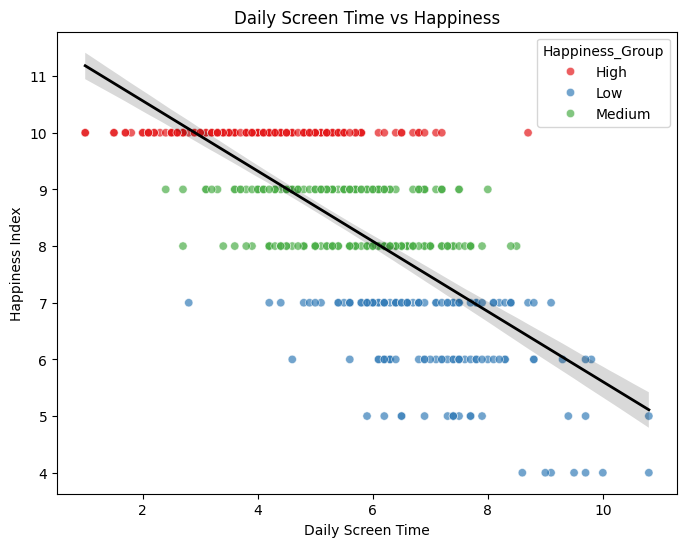

In [18]:
plt.figure(figsize=(8,6))

sns.scatterplot(x="Daily_Screen_Time(hrs)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

sns.regplot(x="Daily_Screen_Time(hrs)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2})

plt.title("Daily Screen Time vs Happiness")
plt.xlabel("Daily Screen Time")
plt.ylabel("Happiness Index")
plt.show()



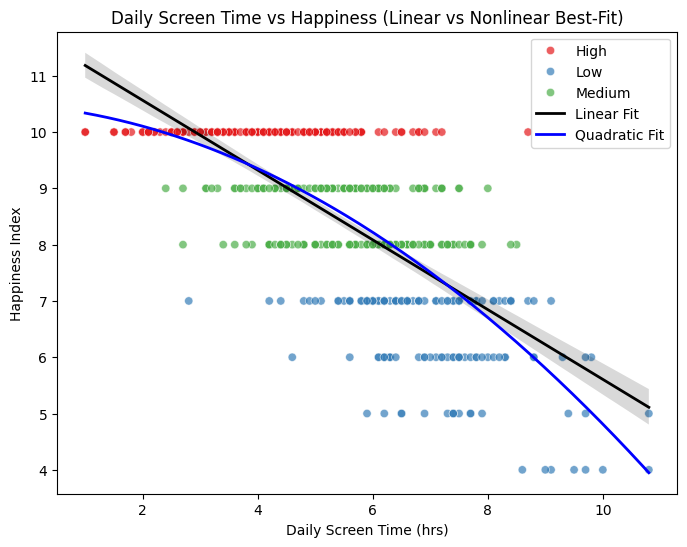

Linear R²: 0.4973150884138853
Quadratic R²: 0.5134258590460679
3rd Degree Quadratic R²: 0.28223689488194104


In [19]:
plt.figure(figsize=(8,6))

# ---------------------------------------------------------
# Scatterplot
# ---------------------------------------------------------
sns.scatterplot(x="Daily_Screen_Time(hrs)",
                y="Happiness_Index(1-10)",
                data=df,
                hue="Happiness_Group",
                palette="Set1",
                alpha=0.7)

# ---------------------------------------------------------
# Linear Regression Line
# ---------------------------------------------------------
sns.regplot(x="Daily_Screen_Time(hrs)",
            y="Happiness_Index(1-10)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2},
            label="Linear Fit")

# ---------------------------------------------------------
# Polynomial Regression
# ---------------------------------------------------------
x = df["Daily_Screen_Time(hrs)"].values
y = df["Happiness_Index(1-10)"].values

coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_range = np.linspace(x.min(), x.max(), 200)
y_pred_poly = poly(x_range)

plt.plot(x_range, y_pred_poly, color="blue", linewidth=2, label="Quadratic Fit")

plt.title("Daily Screen Time vs Happiness (Linear vs Nonlinear Best-Fit)")
plt.xlabel("Daily Screen Time (hrs)")
plt.ylabel("Happiness Index")
plt.legend()
plt.show()

# ---------------------------------------------------------
# R^2 Calculations
# ---------------------------------------------------------
coeffs_lin = np.polyfit(x, y, 1)
lin = np.poly1d(coeffs_lin)
y_pred_lin = lin(x)

r2_linear = r2_score(y, y_pred_lin)

y_pred_quad = poly(x)
r2_quadratic = r2_score(y, y_pred_quad)

y_pred_quad3 = poly3(x)
r2_quadratic3 = r2_score(y, y_pred_quad3)

print("Linear R²:", r2_linear)
print("Quadratic R²:", r2_quadratic)
print("3rd Degree Quadratic R²:", r2_quadratic3)

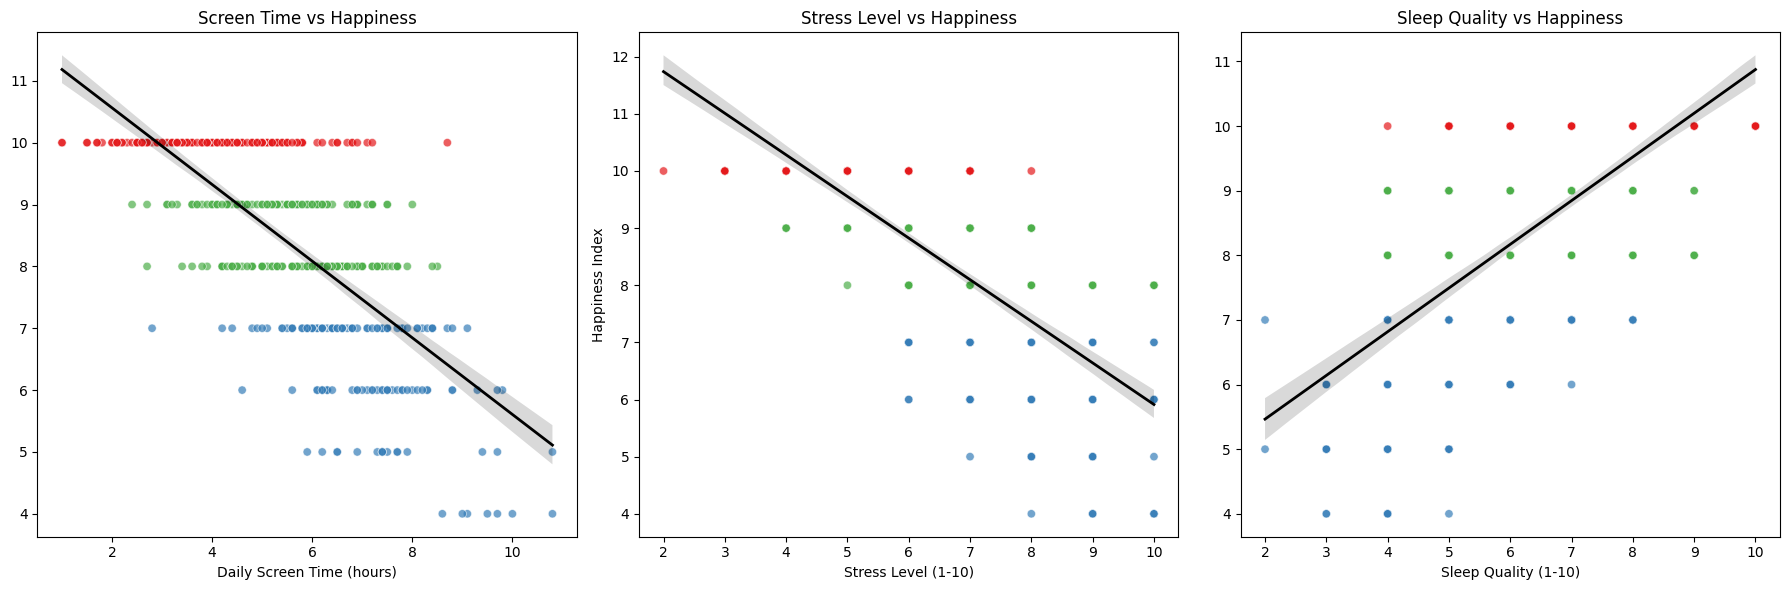

In [20]:

plt.figure(figsize=(18,6))

# -----------------------------------------
# 1. Stress Level vs Happiness
# -----------------------------------------
plt.subplot(1, 3, 2)
sns.scatterplot(
    x="Stress_Level(1-10)",
    y="Happiness_Index(1-10)",
    data=df,
    hue="Happiness_Group",
    palette="Set1",
    alpha=0.7,
    legend=False
)
sns.regplot(
    x="Stress_Level(1-10)",
    y="Happiness_Index(1-10)",
    data=df,
    scatter=False,
    color="black",
    line_kws={"linewidth": 2}
)
plt.title("Stress Level vs Happiness")
plt.xlabel("Stress Level (1-10)")
plt.ylabel("Happiness Index")


# -----------------------------------------
# 2. Sleep Quality vs Happiness
# -----------------------------------------
plt.subplot(1, 3, 3)
sns.scatterplot(
    x="Sleep_Quality(1-10)",
    y="Happiness_Index(1-10)",
    data=df,
    hue="Happiness_Group",
    palette="Set1",
    alpha=0.7,
    legend=False
)
sns.regplot(
    x="Sleep_Quality(1-10)",
    y="Happiness_Index(1-10)",
    data=df,
    scatter=False,
    color="black",
    line_kws={"linewidth": 2}
)
plt.title("Sleep Quality vs Happiness")
plt.xlabel("Sleep Quality (1-10)")
plt.ylabel("")


# -----------------------------------------
# 3. Screen Time vs Happiness
# -----------------------------------------
plt.subplot(1, 3, 1)
sns.scatterplot(
    x="Daily_Screen_Time(hrs)",
    y="Happiness_Index(1-10)",
    data=df,
    hue="Happiness_Group",
    palette="Set1",
    alpha=0.7,
    legend=False
)
sns.regplot(
    x="Daily_Screen_Time(hrs)",
    y="Happiness_Index(1-10)",
    data=df,
    scatter=False,
    color="black",
    line_kws={"linewidth": 2}
)
plt.title("Screen Time vs Happiness")
plt.xlabel("Daily Screen Time (hours)")
plt.ylabel("")

plt.tight_layout()
plt.show()

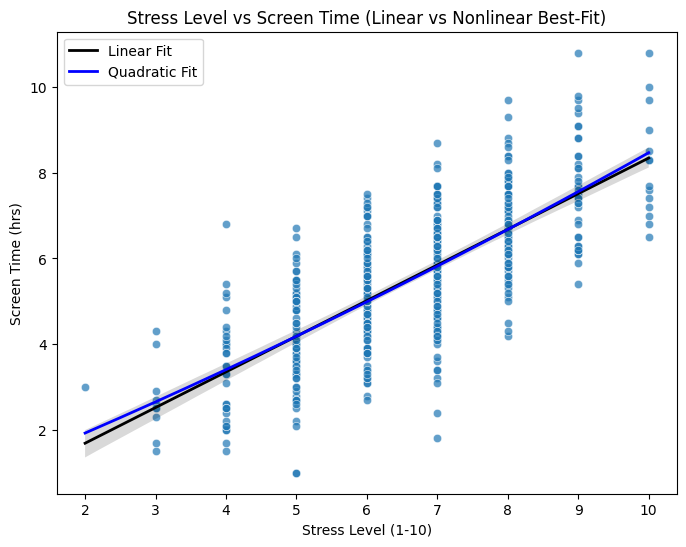

Linear R²: 0.5474387039876474
Quadratic R²: 0.5479775113599323
3rd Degree Quadratic R²: -4.105380769227433


In [21]:
plt.figure(figsize=(8,6))

# ---------------------------------------------------------
# Scatterplot
# ---------------------------------------------------------
sns.scatterplot(x="Stress_Level(1-10)",
                y="Daily_Screen_Time(hrs)",
                data=df,
                palette="Set1",
                alpha=0.7)

# ---------------------------------------------------------
# Linear Regression Line
# ---------------------------------------------------------
sns.regplot(x="Stress_Level(1-10)",
            y="Daily_Screen_Time(hrs)",
            data=df,
            scatter=False,
            color="black",
            line_kws={"linewidth": 2},
            label="Linear Fit")

# ---------------------------------------------------------
# Polynomial Regression
# ---------------------------------------------------------
x = df["Stress_Level(1-10)"].values
y = df["Daily_Screen_Time(hrs)"].values

coeffs = np.polyfit(x, y, 2)
poly = np.poly1d(coeffs)

x_range = np.linspace(x.min(), x.max(), 200)
y_pred_poly = poly(x_range)

plt.plot(x_range, y_pred_poly, color="blue", linewidth=2, label="Quadratic Fit")

plt.title("Stress Level vs Screen Time (Linear vs Nonlinear Best-Fit)")
plt.xlabel("Stress Level (1-10)")
plt.ylabel("Screen Time (hrs)")
plt.legend()
plt.show()

# ---------------------------------------------------------
# R^2 Calculations
# ---------------------------------------------------------
coeffs_lin = np.polyfit(x, y, 1)
lin = np.poly1d(coeffs_lin)
y_pred_lin = lin(x)

r2_linear = r2_score(y, y_pred_lin)

y_pred_quad = poly(x)
r2_quadratic = r2_score(y, y_pred_quad)

y_pred_quad3 = poly3(x)
r2_quadratic3 = r2_score(y, y_pred_quad3)

print("Linear R²:", r2_linear)
print("Quadratic R²:", r2_quadratic)
print("3rd Degree Quadratic R²:", r2_quadratic3)

In [22]:
corr = df["Daily_Screen_Time(hrs)"].corr(df["Stress_Level(1-10)"])
print("Correlation between Screen Time and Stress Levels:", corr)

Correlation between Screen Time and Stress Levels: 0.7398910081813722
